<a href="https://colab.research.google.com/github/anunav83/SparkProject-UCBerkeley/blob/master/Final_Project_Recommendations_for_Investors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project : Home Investment Recommendations
By: Anupama Navaneethan

Date: 11/04/2018

The goal of an investor is to buy a property that has a high rental income and also a high expected price appreciation. In this project we will recommend location (zipcode) of such properties.

Downloaded Dataset from following locations. Zillow Research :  Zip_PriceToRentRatio_AllHomes.csv and AllRegionsForePublic.csv:

*  **Zip_PriceToRentRatio_AllHomes:** The ratio of home prices to annual rental rates.
*  **AllRegionsForePublic**: Forecast of Year-over-year-percentage-change 



[Project Requirements](https://docs.google.com/document/d/1e8pegA_FI4IOb-uhO1jd8dr46VIqmxmvtQPKnWfjjRo/)

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
Set the locations where Spark and Java are installed.

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

# Download Data
Make `data` directory and download file.

In [0]:
from google.colab import files
uploaded = files.upload()

Saving Zip_PriceToRentRatio_AllHomes.csv to Zip_PriceToRentRatio_AllHomes (1).csv
Saving AllRegionsForePublic.csv to AllRegionsForePublic (1).csv


In [0]:
pprr_df = spark.read.csv("Zip_PriceToRentRatio_AllHomes.csv", inferSchema = True, header = True)
pprr_df.show()


+--------+----------+-------------+-----+--------------------+-------------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
|RegionID|RegionName|         City|State|               Metro|   CountyName|SizeRank|2010-10|2010-11|2010-12|2011-01|2011-02|2011-03|2011-04|2011-

In [0]:
from pyspark.sql.types import *

forecast_df = spark.read.csv("AllRegionsForePublic.csv", inferSchema = True, header = True)
forecast_df.show()
forecast_df.dtypes

+---+------+--------------------+---------+-------+----------+--------+--------------------+
|_c0|Region|          RegionName|StateName|MSAName|CountyName|CityName|ForecastYoYPctChange|
+---+------+--------------------+---------+-------+----------+--------+--------------------+
|  1| State|              Alaska|       AK|     NA|        NA|      NA|   -3.22533849129594|
|  2| State|             Alabama|       AL|     NA|        NA|      NA|   0.591582229150434|
|  3| State|            Arkansas|       AR|     NA|        NA|      NA|    8.34934853420195|
|  4| State|             Arizona|       AZ|     NA|        NA|      NA|    3.82502044153721|
|  5| State|          California|       CA|     NA|        NA|      NA|     8.2706918700679|
|  6| State|            Colorado|       CO|     NA|        NA|      NA|    9.16191252377072|
|  7| State|         Connecticut|       CT|     NA|        NA|      NA|    3.88751033912325|
|  8| State|District of Columbia|       DC|     NA|        NA|      NA

[('_c0', 'int'),
 ('Region', 'string'),
 ('RegionName', 'string'),
 ('StateName', 'string'),
 ('MSAName', 'string'),
 ('CountyName', 'string'),
 ('CityName', 'string'),
 ('ForecastYoYPctChange', 'double')]

#Project Tasks



## 1.  Find the top-100 zip-codes with highest predicted-YoYPctChange

The forecast dataframe has the forecasted percentage change by region. We would like the recommendations made based on ZipCodes. 

In [0]:
import pyspark.sql.functions as funcs
import pandas as pd

regioncategory = forecast_df.groupBy('Region').agg(funcs.count(funcs.lit(1)).alias("count"))
regioncategory.show()


+------------+-----+
|      Region|count|
+------------+-----+
|      County| 1882|
|       State|   51|
|Neighborhood| 7419|
|         Zip|15252|
|     Country|    1|
|         Msa|  774|
|        City|12673|
+------------+-----+



There are a total of 15252 zipcodes, of which we need to find top 100 zip codes that have the highest value for "ForecastYoYPctChange" column (index= 7). Filter the dataframe to have only Region = zip


In [0]:

from pyspark.sql import Window
from pyspark.sql.functions import desc
import pyspark.sql.functions as funcs

# column 'RegionName' is renamed to zip
filtered_forecast_df = forecast_df.select(forecast_df.Region, forecast_df.RegionName.alias('Zip'), forecast_df.ForecastYoYPctChange,forecast_df.StateName, forecast_df.CountyName, forecast_df.CityName).filter(forecast_df.Region == 'Zip')
# Use fwindow function to order the dataframe
forecast_windows = Window.orderBy(desc('ForecastYoYPctChange'))
    
# to get top 100, assign dense rank based on the ForecastYoYPctChange valu
filtered_forecast_df = filtered_forecast_df.withColumn("DenseRank", funcs.dense_rank().over(forecast_windows))
filtered_forecast_df_top100 = filtered_forecast_df.filter(filtered_forecast_df.DenseRank <= 100)
filtered_forecast_df_top100.show()

#Make sure there are 100 distinct Zip Codes

#filtered_forecast_df.select('Zip').distinct().count()

+------+-----+--------------------+---------+-----------+-------------+---------+
|Region|  Zip|ForecastYoYPctChange|StateName| CountyName|     CityName|DenseRank|
+------+-----+--------------------+---------+-----------+-------------+---------+
|   Zip|01340|    19.9185022026432|       MA|   Franklin|      Colrain|        1|
|   Zip|37687|    19.8496835443038|       TN|     Carter|Roan Mountain|        2|
|   Zip|01376|    19.8286180631121|       MA|   Franklin|Turners Falls|        3|
|   Zip|79603|    19.8167664670659|       TX|     Taylor|      Abilene|        4|
|   Zip|44306|    19.7807228915663|       OH|     Summit|        Akron|        5|
|   Zip|94020|    19.7692643051771|       CA|  San Mateo|     La Honda|        6|
|   Zip|32087|    19.7629107981221|       FL|      Baker|    Sanderson|        7|
|   Zip|49659|    19.7232796486091|       MI|     Antrim|    Mancelona|        8|
|   Zip|95127|    19.6071819841753|       CA|Santa Clara|     San Jose|        9|
|   Zip|01301|  

##2.  Find the top-100 zip-codes with highest Price-per-rent-ratio

The price per rent ratio  dataframe has the rato for each yaer starting 2010 to 2018. For this exercise we will be considering the most recent values. The region name is the zip code.


In [0]:

# RegionName in PPRR csv is the zip code. There 15480 distinct zip codes
regionname = pprr_df.groupBy('RegionName').agg(funcs.count(funcs.lit(1)).alias("counts"))
regionname.select('RegionName').distinct().count()   



15480

There are a total of 15480  zipcodes, of which we need to find top 100 zip codes that have the highest value for "price per rent ratio " for the latest values.(2018-09)

In [0]:

# column 'RegionName' is renamed to zip
filtered_pprr_df = pprr_df.select(pprr_df.RegionName.alias('Zip'),pprr_df.Metro, pprr_df.City, pprr_df.CountyName.alias('County'),pprr_df.State, pprr_df['2018-09'].alias('latestpriceperrentratio'))
filtered_pprr_df.show()



+-----+--------------------+-------------+-------------+-----+-----------------------+
|  Zip|               Metro|         City|       County|State|latestpriceperrentratio|
+-----+--------------------+-------------+-------------+-----+-----------------------+
|10025|New York-Newark-J...|     New York|     New York|   NY|                  25.48|
|60657|Chicago-Napervill...|      Chicago|         Cook|   IL|                  14.06|
|10023|New York-Newark-J...|     New York|     New York|   NY|                  24.04|
|77494|Houston-The Woodl...|         Katy|       Harris|   TX|                  11.59|
|60614|Chicago-Napervill...|      Chicago|         Cook|   IL|                  14.94|
|79936|             El Paso|      El Paso|      El Paso|   TX|                  10.62|
|77449|Houston-The Woodl...|         Katy|       Harris|   TX|                  10.44|
|77084|Houston-The Woodl...|      Houston|       Harris|   TX|                  10.33|
|10002|New York-Newark-J...|     New York| 

In [0]:
# Use window function to order the dataframe

from pyspark.sql import Window
pprr_window = Window.orderBy(desc('latestpriceperrentratio'))
    
# to get top 100, assign dense rank based on the ForecastYoYPctChange valu
filtered_pprr_df = filtered_pprr_df.withColumn("DenseRank", funcs.dense_rank().over(pprr_window))
filtered_pprr_df_top100 = filtered_pprr_df.filter(filtered_pprr_df.DenseRank <= 100)
filtered_pprr_df_top100.show()

+-----+--------------------+--------------+-----------+-----+-----------------------+---------+
|  Zip|               Metro|          City|     County|State|latestpriceperrentratio|DenseRank|
+-----+--------------------+--------------+-----------+-----+-----------------------+---------+
|94087|San Jose-Sunnyval...|     Sunnyvale|Santa Clara|   CA|                  38.77|        1|
|95129|San Jose-Sunnyval...|      San Jose|Santa Clara|   CA|                  38.22|        2|
|94086|San Jose-Sunnyval...|     Sunnyvale|Santa Clara|   CA|                  37.59|        3|
|95014|San Jose-Sunnyval...|     Cupertino|Santa Clara|   CA|                  36.95|        4|
|94027|San Francisco-Oak...|      Atherton|  San Mateo|   CA|                   36.4|        5|
|94041|San Jose-Sunnyval...| Mountain View|Santa Clara|   CA|                  36.39|        6|
|94010|San Francisco-Oak...|    Burlingame|  San Mateo|   CA|                  36.22|        7|
|94028|San Francisco-Oak...|Portola Vall

##3.  Find the top-100 zip-codes with highest Score

To calculate score we divide Forecasted year to year change by price per rent ratio. Not all Zip Codes in PPRR dataframe have a Forecasted Year to year change. For these values we will be using the city's forecasted value. Metro is not reported in the forecast data, hence we will not be using it. If the city doesnt exist we will be using the county. If the county does not exist then we will use the forecasted value of the state.

In [0]:


score_by_zip_df = filtered_pprr_df.join(filtered_forecast_df, "Zip")
score_df = score_by_zip_df.select("Zip","City","State","County","latestpriceperrentratio","ForecastYoYPctChange","Region")
#score_df.show()


In [0]:
#FOR MISSING ZIP, FIND QUIVALENT CITY VALUE

# There are 321 zipcodes that dont have a valid forecast value. We would need to find the city on these records.

filtered_city_pprr_df = filtered_pprr_df.join(filtered_forecast_df,"Zip", how ='left')
filtered_city_pprr_df = filtered_city_pprr_df.filter(filtered_forecast_df.ForecastYoYPctChange.isNull())
filtered_city_pprr_df = filtered_city_pprr_df.select("Zip","City","State","County","latestpriceperrentratio")

#Get forecast values based on the Cities
filtered_city_forecast_df = forecast_df.select(forecast_df.Region, forecast_df.RegionName.alias('City'),forecast_df.StateName.alias('State'),forecast_df.CountyName.alias('County'),forecast_df.ForecastYoYPctChange).filter(forecast_df.Region == 'City')

#Get score by city
score_by_city_df = filtered_city_pprr_df.join(filtered_city_forecast_df, ['City','State','County'])
score_by_city_df = score_by_city_df.select("Zip","City","State","County","latestpriceperrentratio","ForecastYoYPctChange","Region")


In [0]:
#FOR MISSING CITY, FIND QUIVALENT COUNTY VALUE

# There are 291 zipcodes that dont have a valid forecast value. We would need to find the county on these records.

filtered_county_pprr_df = filtered_city_pprr_df.join(filtered_city_forecast_df, ['City','State','County'], how ='left')
filtered_county_pprr_df = filtered_county_pprr_df.filter(filtered_city_forecast_df.ForecastYoYPctChange.isNull())
filtered_county_pprr_df = filtered_county_pprr_df.select("Zip","City","State","County","latestpriceperrentratio")

#Get forecast values based on the County
filtered_county_forecast_df = forecast_df.select(forecast_df.Region,forecast_df.StateName.alias('State'),forecast_df.CountyName.alias('County'),forecast_df.ForecastYoYPctChange).filter(forecast_df.Region == 'County')

#Get score by county
score_by_county_df = filtered_county_pprr_df.join(filtered_county_forecast_df, ['State','County'])
score_by_county_df = score_by_county_df.select("Zip","City","State","County","latestpriceperrentratio","ForecastYoYPctChange","Region")
#score_by_county_df.show()


In [0]:
#FOR MISSING COUNTY, FIND QUIVALENT STATE VALUE

# There are 259 zipcodes that dont have a valid forecast value. We would need to find the County on these records.
# PPRR dataframe has the highest number of distinct zip codes which is why we will do the left join on the forecast dataframe
# also to calculate score PPRR is the denominator, hence we need to have a PPRR value

filtered_state_pprr_df = filtered_county_pprr_df.join(filtered_county_forecast_df, ['State','County'], how ='left')
filtered_state_pprr_df = filtered_state_pprr_df.filter(filtered_county_forecast_df.ForecastYoYPctChange.isNull())
filtered_state_pprr_df = filtered_state_pprr_df.select("Zip","City","State","County","latestpriceperrentratio")

#Get forecast values based on the County
filtered_state_forecast_df = forecast_df.select(forecast_df.Region,forecast_df.StateName.alias('State'),forecast_df.ForecastYoYPctChange).filter(forecast_df.Region == 'State')

#Get score by county
score_by_state_df = filtered_state_pprr_df.join(filtered_state_forecast_df, 'State')
score_by_state_df = score_by_state_df.select("Zip","City","State","County","latestpriceperrentratio","ForecastYoYPctChange","Region")
#score_by_state_df.show()




In [0]:
final = filtered_state_pprr_df.join(filtered_state_forecast_df, 'State', how ='left')
final = final.filter(final.ForecastYoYPctChange.isNull())
#final.show()
# All rows now have a valid forecastYoY value

In [0]:
#Union all the score DFs score_df, score_by_city_df, score_by_county_df, score_by_state_df. The count of distinct zip codes is same as the original price per rent ratio dataframe.

final_score = score_df.union(score_by_city_df)
final_score = final_score.union(score_by_county_df)
final_score = final_score.union(score_by_state_df)

final_score.select('Zip').distinct().count()

15480

In [0]:
# Calculate the score, The Region column tells if the forecasted value is based on the Zip, City, County or the state.

final_score = final_score.withColumn("score",final_score.ForecastYoYPctChange/final_score.latestpriceperrentratio )

score_window = Window.orderBy(desc('score'))
    
# to get top 100, assign dense rank based on the score value
final_score = final_score.withColumn("DenseRank", funcs.dense_rank().over(score_window))
final_score_top100 = final_score.filter(final_score.DenseRank <= 100)
final_score_top100.show()

+-----+-----------------+-----+--------+-----------------------+--------------------+------+------------------+---------+
|  Zip|             City|State|  County|latestpriceperrentratio|ForecastYoYPctChange|Region|             score|DenseRank|
+-----+-----------------+-----+--------+-----------------------+--------------------+------+------------------+---------+
|11726|         Copiague|   NY| Suffolk|                   2.09|    10.6066368381805|   Zip| 5.074945855588756|        1|
|11703|    North Babylon|   NY| Suffolk|                   3.58|    17.0525087514586|   Zip|  4.76327060096609|        2|
|11757|      Lindenhurst|   NY| Suffolk|                    2.7|    11.8087211432759|   Zip| 4.373600423435518|        3|
| 3215|Waterville Valley|   NH| Grafton|                   2.59|    10.2567567567567|   Zip|3.9601377439215057|        4|
|11704|     West Babylon|   NY| Suffolk|                   3.34|    12.9303170409511|   Zip|  3.87135240747039|        5|
|13365|     Little Falls

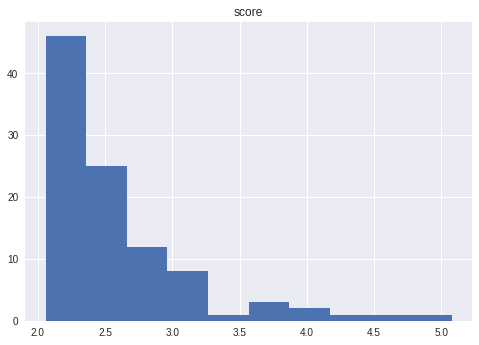

In [0]:
final_score_top100_p =final_score_top100.toPandas()
final_score_top100_p.hist('score');


